## Inventory Forecasting Analysis

In [9]:
#Grab historical Sales data
#Seasonality Variables, Qtr, Period
#Event sku?
# Sku age
# CPI
%matplotlib inline

In [10]:
print(str(60000*60*365))

1314000000


In [11]:
import sys
sys.path.insert(0, r"C:\users\pairwin\Documents\Github\HelperPI")

import HelperPI
import seaborn as sbs
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as sts

In [12]:
helper = HelperPI.Helper()

INFO:root:Initializing...


### Grabbing the data via pyodbc

In [15]:
sql = helper.getSQL(r"C:\users\pairwin\Documents\GitHub\IPy_Notebooks\SQL\InventoryForecasting.sql")

In [16]:
base, dtypesdf = helper.readData(sql)

INFO:root:Reading data...
INFO:root:Data read complete...
INFO:root:Read: 1170 rows.


                Count Column Type
0          DATE_VALUE      object
1    CALENDAR_QUARTER       int64
2      CALENDAR_MONTH       int64
3           DAYINWEEK       int64
4             UMCSENT     float64
5        STORE_NUMBER      object
6  SKU_DISPLAY_NUMBER      object
7             SKU_AGE       int64
8           EVENT_SKU       int64
9        TARGET_UNITS     float64


In [18]:
base.describe()

,CALENDAR_QUARTER,CALENDAR_MONTH,DAYINWEEK,UMCSENT,SKU_AGE,EVENT_SKU,TARGET_UNITS
count,1170.000000,1170.000000,1170.000000,1170.000000,1170.0,1170.000000,1170.000000
mean,2.341026,6.005128,4.047009,90.652308,9432.0,0.048718,17.630769
std,1.117912,3.453463,2.006067,5.356178,0.0,0.215370,59.361966
min,1.000000,1.000000,1.000000,80.000000,9432.0,0.000000,1.000000
25%,1.000000,3.000000,2.000000,87.200000,9432.0,0.000000,4.000000
50%,2.000000,6.000000,4.000000,91.300000,9432.0,0.000000,8.000000
75%,3.000000,9.000000,6.000000,95.400000,9432.0,0.000000,14.000000
max,4.000000,12.000000,7.000000,98.500000,9432.0,1.000000,1076.000000


### Preliminary OLS results

In [17]:
formula = 'TARGET_UNITS ~ C(CALENDAR_MONTH) + C(EVENT_SKU) + C(DAYINWEEK) + UMCSENT'
model = sts.ols(formula, data=base).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           TARGET_UNITS   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     37.65
Date:                Fri, 18 Aug 2017   Prob (F-statistic):          1.28e-106
Time:                        14:23:17   Log-Likelihood:                -6154.6
No. Observations:                1170   AIC:                         1.235e+04
Df Residuals:                    1150   BIC:                         1.245e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -6.0691     26.533     -0.229      0.819     -58.128      45.990
C(CALENDAR_MONTH)[T.2]     -4.2374      6.592     -0.643      0.520     -17.171       8.697
C(CALENDAR_MONTH)[T.3]     19.5670      6.103      3.206      0.001       7.592      31.542
C(CALENDAR_MONTH)[T.4]      3.8350      6.230      0.616      0.538      -8.389      16.059
C(CALENDAR_MONTH)[T.5]      0.6422      6.150      0.104      0.917     -11.424      12.709
C(CALENDAR_MONTH)[T.6]     -6.3831      6.759     -0.944      0.345     -19.645       6.879
C(CALENDAR_MONTH)[T.7]      0.0017      6.798      0.000      1.000     -13.336      13.339
C(CALENDAR_MONTH)[T.8]     -0.1734      6.753     -0.026      0.980     -13.423      13.076
C(CALENDAR_MONTH)[T.9]     -1.9379      6.820     -0.284      0.776     -15.320      11.444
C(CALENDAR_MONTH)[T.10]    -2.8770      6.736     -0.427      0.669     -16.094      10.340
C(CALENDAR_MONTH)[T.11]    -2.4859      7.070     -0.352      0.725     -16.357      11.386
C(CALENDAR_MONTH)[T.12]     2.7791      6.654      0.418      0.676     -10.276      15.834
C(EVENT_SKU)[T.1]         168.6095      7.084     23.801      0.000     154.710     182.509
C(DAYINWEEK)[T.2]           2.4630      5.206      0.473      0.636      -7.752      12.678
C(DAYINWEEK)[T.3]          -1.8217      5.220     -0.349      0.727     -12.064       8.421
C(DAYINWEEK)[T.4]          -2.0917      5.177     -0.404      0.686     -12.249       8.066
C(DAYINWEEK)[T.5]          -1.6224      5.172     -0.314      0.754     -11.769       8.524
C(DAYINWEEK)[T.6]           4.1937      5.139      0.816      0.415      -5.888      14.276
C(DAYINWEEK)[T.7]           9.4472      5.125      1.843      0.066      -0.608      19.502
UMCSENT                     0.1389      0.280      0.495      0.620      -0.411       0.689
==============================================================================
Omnibus:                     1847.211   Durbin-Watson:                   0.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1192364.611
Skew:                           9.474   Prob(JB):                         0.00
Kurtosis:                     158.241   Cond. No.                     1.80e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Data Description

In [36]:
base.describe()

,CALENDAR_QUARTER,CALENDAR_MONTH,DAYINWEEK,UMCSENT,SKU_AGE,EVENT_SKU,TARGET_UNITS
count,1078.000000,1078.000000,1078.000000,1078.000000,1078.0,1078.000000,1078.000000
mean,2.406308,6.202226,4.072356,90.517254,6033.0,0.012987,13.731911
std,1.171480,3.638737,2.010270,5.318645,0.0,0.113271,22.987371
min,1.000000,1.000000,1.000000,80.000000,6033.0,0.000000,1.000000
25%,1.000000,3.000000,2.000000,87.200000,6033.0,0.000000,3.000000
50%,2.000000,6.000000,4.000000,91.300000,6033.0,0.000000,6.000000
75%,4.000000,10.000000,6.000000,94.700000,6033.0,0.000000,15.000000
max,4.000000,12.000000,7.000000,98.500000,6033.0,1.000000,254.000000


### Point Biserial Correlation
For Target_Units vs the Event Sku flag.

In [19]:
corr, pval = stats.pointbiserialr(base['EVENT_SKU'], base['TARGET_UNITS'])
print('Point Biserial Correlation \n Coeff: ' + str(corr) + '\n pval: ' + str(pval))

Point Biserial Correlation 
 Coeff: 0.604804470278
 pval: 1.23200476493e-117


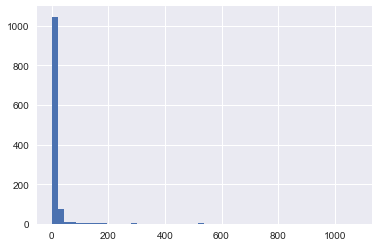

In [20]:
plt.hist(base['TARGET_UNITS'], bins=50)
plt.show()